In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

## Preprocessing Hate Map Data from SPLC

The Hate Map data is all from the [SPLC](https://www.splcenter.org/hate-map). They have data from, I believe, 2000 until 2017 available. I used [StackOverflow](https://stackoverflow.com/questions/44549110/python-loop-through-excel-sheets-place-into-one-df) help with reading in from an excel file with multiple sheets.

In [2]:
# first, getting the excel file which has each year's data in a different sheet

xl_file = "/Users/gemma/Documents/data science/splc-hate-groups-previous-years.xls"

# reading it in as a dict to then make the dataframe from that dict
sheets_dict = pd.read_excel(xl_file, sheet_name=None)

hatemaps = pd.DataFrame()
for name, sheet in sheets_dict.items():
    sheet['year'] = int(name)
    # some of the col names arent standardized the same across years - correcting that here
    if 'City/Region' in sheet.columns.values:
        sheet.rename(columns={'City/Region':'City'}, inplace=True)
    if 'Group name' in sheet.columns.values:
        sheet.rename(columns={'Group name':'Group Name'}, inplace=True) 
       
    hatemaps = hatemaps.append(sheet, sort=False)

hatemaps.reset_index(inplace=True, drop=True)

Let's take a look at the data available to us from the excel file:

In [3]:
hatemaps.head()

,Group Name,City,State,Hate Type,year,Unnamed: 4,Unnamed: 5
0,American Christian Dixie Knights of the Ku Klu...,NaN,AL,Ku Klux Klan,2017,NaN,NaN
1,American Confederate Knights of the Ku Klux Klan,NaN,TN,Ku Klux Klan,2017,NaN,NaN
2,Church of the American Christian Knights,Moselle,MS,Ku Klux Klan,2017,NaN,NaN
3,Church of the National Knights of the Ku Klux ...,NaN,KY,Ku Klux Klan,2017,NaN,NaN
4,Church of the National Knights of the Ku Klux ...,Panama,NY,Ku Klux Klan,2017,NaN,NaN


In [4]:
# let's look at the last two columns - 5 contains only NaN, what about 4? 
hatemaps.sort_values(by='Unnamed: 4', ascending=False)

hatemaps.groupby(['year'])['Unnamed: 4'].count().head(10)

year
2000     0
2001     0
2002     0
2003     0
2004     0
2005     0
2006     0
2007    90
2008     0
2009     0
Name: Unnamed: 4, dtype: int64

In [5]:
# since columns "Unnamed 4" and "5" contain either no data (5) or data only for 2007 (4)...
hatemaps.drop(['Unnamed: 5', 'Unnamed: 4'], axis=1, inplace=True)

Since the table has all of the hatemaps from 2000 through 2017, but the FBI data only goes from 2004 through 2016, we'll drop the Hate Maps data that we're not going to be using from the table, so as to save memory.

In [6]:
hatemaps = hatemaps.query('(year > 2003) & (year < 2017)')

# double checking it worked
hatemaps['year'].unique()

array([2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006,
       2005, 2004])

In [7]:
# looking at some of the string data that could be inconsistent...

hatemaps['Hate Type'].unique()

array([' Ku Klux Klan', 'Neo-Nazi', 'White Nationalist',
       'Racist Skinhead', 'Christian Identity', 'Black Nationalist',
       'Neo-Confederate', 'Anti-LGBT', 'Anti-Muslim', 'Anti-Immigration',
       'General Hate', 'Holocaust Denial', 'Racist Music',
       'Radical Traditional Catholicism', 'Anti-Immigrant',
       'Ku Klux Klan', 'GH_Anti-Immigration', 'GH_Anti-LGBT',
       'GH_Anti-Muslim', 'GH_Holocaust_Denial', 'GH_Other',
       'GH_Racial_Music', 'GH_Radical_Trad_Catholilicism', 'ANTI-LGBT',
       'Other', 'Radical Traditional Catholilic', 'GH_Anti-Gay',
       'Anti-Gay', 'Radical Traditionalist Catholic', 'General/Anti-Gay',
       'General/Anti-Immigrant', 'General/Holocaust Denial',
       'General/Other', 'General/Racist Music',
       'General/Radical Catholic'], dtype=object)

In [8]:
# preparing a dict of the Hate Group types that are not consistent

corrects = {' Ku Klux Klan': 'Ku Klux Klan','GH_Anti-Muslim' :'Anti-Muslim' , }

corrects.update(corrects.fromkeys(['GH_Anti-LGBT',
                                  'ANTI-LGBT','Anti-Gay','GH_Anti-Gay',
                                  'General/Anti-Gay'],'Anti-LGBT'))

corrects.update(corrects.fromkeys(['GH_Radical_Trad_Catholilicism', 'Radical Traditional Catholicism ',
                                  'Radical Traditional Catholilic',
                                 'Radical Traditionalist Catholic', 
                              'General/Radical Catholic'],'Radical Traditional Catholicism'))

corrects.update(corrects.fromkeys(['Anti-Immigration','GH_Anti-Immigration', 
                               'General/Anti-Immigrant'],'Anti-Immigrant'))

corrects.update(corrects.fromkeys(['General Hate','GH_Other', 
                                'Other'],'General/Other'))

corrects.update(corrects.fromkeys(['GH_Holocaust_Denial', 
                               'General/Holocaust Denial'],'Holocaust Denial'))

corrects.update(corrects.fromkeys(['General/Racist Music','Racist Music', 
                                'GH_Racial_Music', 'Hate Music'],'Racist / Hate Music'))

# a little function
def check_and_replace(value):
    if value in corrects:
        return corrects[value]
    else:
        return value

In [9]:
    # making the hate types consistent

hatemaps['Hate Type'] = hatemaps['Hate Type'].apply(check_and_replace)

In [10]:
hatemaps['Hate Type'].unique()

array(['Ku Klux Klan', 'Neo-Nazi', 'White Nationalist', 'Racist Skinhead',
       'Christian Identity', 'Black Nationalist', 'Neo-Confederate',
       'Anti-LGBT', 'Anti-Muslim', 'Anti-Immigrant', 'General/Other',
       'Holocaust Denial', 'Racist / Hate Music',
       'Radical Traditional Catholicism'], dtype=object)

In [11]:
# the names of the hate groups are also a mess... let's clean them up

# dropping punctuation / strange characters
import re
def cleanup(text):
    # get rid of anything that is not a letter
    text = re.sub(r'[ˆ0-9]+[^\s]+[\W]+\*+','',text)   
    text = re.sub(r'\*+', '', text) # get rid of *s
    text = re.sub(r'[\\x]+', '', text) # get rid of \xs
    text = re.sub(r'\\+', '', text) # get rid of \s
    #text = re.sub(r'"', '', text) # get rid of "s
    text = ' '.join(text.split('  ')) # get rid of extra spaces
    text = text.lower()     # make it all lowercase
    return text

In [12]:
hatemaps['Group Name'] = hatemaps['Group Name'].apply(cleanup)

In [13]:
hatemaps.head()

,Group Name,City,State,Hate Type,year
954,christian american knights of the ku klu klan,Cocoa,FL,Ku Klux Klan,2016
955,church of the national knights of the ku klu klan,Panama,NY,Ku Klux Klan,2016
956,confederate white knights of the ku klu klan,Rosedale,MD,Ku Klux Klan,2016
957,east coast knights of the true invisible empire,Venus,TX,Ku Klux Klan,2016
958,georgia knight riders of the ku klu klan,Live Oak,FL,Ku Klux Klan,2016


## Preprocessing Hate Crime Data from FBI 

FBI data from [UCR](https://www.fbi.gov/services/cjis/ucr/publications#Hate-Crime%20Statistics). (Years prior to 2004 are available as pdfs only.)

FBI data key: 

* Table 1: Incidents, Offenses, Victims, and Known Offenders by Bias Motivation 
* Table 2: Incidents, Offenses, Victims, and Known Offenders by Offense Type
* Table 3: Offenses: Known Offender's Race by Offense Type
* <font color='green'>Table 4: Offenses: Offense Type by Bias Motivation</font> <strong>!!!</strong>
* Table 5: Offenses: Known Offender's Race by Bias Motivation
* Table 6: Offenses: Victim Type by Offense Type (ie person, business, religious org, etc)
* Table 7: Victims: Offense Type by Bias Motivation (ie number of murders that were in a certain hate crime category such as anti-LGBT)
* Table 8: Incidents: Victim Type  by Bias Motivation
* Table 9: Known Offenders: Known Offender's Race
* Table 10: Incidents: Bias Motivation by Location  (as in, restaurant, store, etc)
* Table 11: Offenses: Offense Type by Participating State
* Table 12: Agency Hate Crime Reporting by State
* <font color='green'>Table 13: Hate Crime Incidents, by Bias Motivation, by State, Agency Type, and Number of Quarters Reported</font> <strong>!!!</strong>

Year 2012 also has a Table 13 Addendum, which has data that was not included in the rest of the tables because it was submit late to the FBI.

Also, Table 13 from 2004 and 2005 is in a different format. So we will narrow down our data to be from 2006 through 2016, unless, from the results, it looks like we will need more data to come to a conclusion..

Year 2004 has Table 4 split into 4-1 and 4-2.

Help with os module from [here](https://www.pythonforbeginners.com/os/pythons-os-module).

In [14]:
target_years = [x for x in range(2006,2017)] 
folder_names = []

# making a list of all the folders
for year in target_years:
    folder_names.append('Hate Crime Statistics '+ str(year) + ' Tables/')
    
# these are the file names for most folders  - see explan. re .xls and .xlsx below, "Methods'
file_names = ['table4.xls','table13.xls', 'table13.xlsx']

path = "/Users/gemma/Documents/data science/Hate Crime FBI Data/"


In [15]:
import os

counter = 0

for folder in folder_names:
    for file in file_names:
        if file in os.listdir(path+folder):
            counter +=1
        else:
            print(False,folder,file)
            
print(counter)

33


In [16]:
# first as a trial, and to check out the format, reading in:

# for table 4:
def create_table4s(full_filename, number):

    # first try at reading in the file
    my_excel = pd.ExcelFile(full_filename, sheet_name=0)

    # find the first row of content - the first Total (there could be more than 1 Total)
    testing = my_excel.parse()

    found = False
    last_row = 0 # (in case it doesn't find the last row as labeled below)
    for row in range(testing.shape[0]):
        if testing.iat[row,0] == "Total" and found == False:
            row_start = row
            found = True
    # find the last row of content  
        if (testing.iat[row,0] == 
            'Multiple-Bias Incidents2') or (testing.iat[row,0] == 'Multiple-Bias Incidents5'):
            last_row = row+1
            break

    # reread it in with the correct header and footer
    table4 = pd.read_excel(my_excel, header=[row_start-1, row_start], 
                  skipfooter=(testing.shape[0]-last_row))

    table4['Year'] = target_years[number] #keeping it in order
    
    return table4


In [17]:
full_filename = path+folder_names[8]+file_names[0]


create_table4s(full_filename, 8)

Bias motivation                                       Total\noffenses  \
                                                   Unnamed: 0_level_1   
Total                                                            6418   
Single-Bias Incidents                                            6385   
Race:                                                            3081   
Anti-White                                                        701   
Anti-Black or African American                                   1955   
Anti-American Indian or Alaska Native                             142   
Anti-Asian                                                        168   
Anti-Native Hawaiian or Other Pacific Islander                      4   
Anti-Multiple Races, Group                                        111   
Religion:                                                        1092   
Anti-Jewish                                                       635   
Anti-Catholic                                                      67   
Anti-Protestant                                                    28   
Anti-Islamic (Muslim)                                             178   
Anti-Other Religion                                               120   
Anti-Multiple Religions, Group                                     51   
Anti-Atheism/Agnosticism/etc.                                      13   
Sexual Orientation:                                              1178   
Anti-Gay (Male)                                                   683   
Anti-Lesbian                                                      168   
Anti-Lesbian, Gay, Bisexual, or Transgender (Mi...                278   
Anti-Heterosexual                                                  18   
Anti-Bisexual                                                      31   
Ethnicity:                                                        790   
Anti-Hispanic or Latino                                           376   
Anti-Not Hispanic or Latino4                                      414   
Disability:                                                        95   
Anti-Physical                                                      26   
Anti-Mental                                                        69   
Gender:                                                            40   
Anti-Male                                                          12   
Anti-Female                                                        28   
Gender Identity:                                                  109   
Anti-Transgender                                                   69   
Anti-Gender Non-Conforming                                         40   
Multiple-Bias Incidents5                                           33   

Bias motivation                                                    Crimes against persons  \
                                                   Murder and\nnonnegligent\nmanslaughter   
Total                                                                                   4   
Single-Bias Incidents                                                                   4   
Race:                                                                                   4   
Anti-White                                                                              3   
Anti-Black or African American                                                          1   
Anti-American Indian or Alaska Native                                                   0   
Anti-Asian                                                                              0   
Anti-Native Hawaiian or Other Pacific Islander                                          0   
Anti-Multiple Races, Group                                                              0   
Religion:                                                                               0   
Anti-Jewish                                                                             0   
Anti-Catholic   

Help with multindexing from [here](https://stackoverflow.com/questions/25189575/pandas-dataframe-select-columns-in-multiindex) [here](https://stackoverflow.com/questions/41251922/error-when-using-pandas-read-excelheader-0-1),  and [here](https://stackoverflow.com/questions/50755480/pandas-multiindex-dataframe-to-excel-second-index-as-column-name), and ffil from the [pandas docs](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.ffill.html) and [stack overflow](https://stackoverflow.com/questions/22937650/pandas-reading-excel-with-merged-cells).

Help with [Renaming header w data from top row](https://stackoverflow.com/questions/31328861/python-pandas-replacing-header-with-top-row/31328974).

Help with the error about plan shapes are not aligned from [stack overflow](https://stackoverflow.com/questions/26226343/pandas-concat-gives-error-valueerror-plan-shapes-are-not-aligned) (it explained that means that there are duplicate columns.). Then, help with dynamically renaming duplicate column headers from [here](https://stackoverflow.com/questions/40774787/renaming-columns-in-a-pandas-dataframe-with-duplicate-column-names).

### Methods

The reason for the duplicate column headers was because of merged cells - in a row, some were merged with another row, and some weren't. So, the ones that weren't merged with another row showed up as NaN. My idea was to find the NaN values in the row and replace them with the valus from the previous row (the merged one), however, looking into that took more time than I had, so I manually unmerged the rows in Excel and saved them as new file (the original files are .xls, the edited files are .xlsx). 

While I was editing the file this way, I also combined table 13 and table 13 addendum from year 2012 into one file.

In [19]:
# FOR TABLE 13, file_names[1] for old version, file_names[2] for edited version

def make_table_13s(this_path, number):
       
    # first time, to find where the header ends
    full_table = pd.read_excel(this_path, index_col=0)
    
    # then we're going to find which row Religion is in, bc it's one category
    # of bias that is in all of the excel files
    
    found = False
    for col in range(full_table.shape[1]):
        for row in range(full_table.shape[0]):
            if full_table.iat[row,col] == "Religion" and found == False:
                row_start = row + 1
                found = True
    
    if found == False:
        print("honey you have a storm coming")
        
    # now we're legit reading it in, with the state as the index
    full_table = pd.read_excel(this_path, header=row_start) #index_col=0)

    # the size of the footer is diff each table, but all of the values are Na, so we'll 
    # get rid of the footer through dropping rows that have only Na values
    
    full_table.dropna(axis=0, how="all", inplace=True)
    
    # renaming columns that are not consistently named across all files, or just bc
    full_table.rename(index=str, 
                      columns={ 'Agency Type': 'Agency type', 
                               'Gender\nIdentity':'Gender Identity',
                               'Race/\nEthnicity/\nAncestry': 'Race / Ethnicity / Ancestry'},
                      inplace=True)

    # there's one more inconsistency, it has to do with changes in how the 
    # biases were classified - they used to split up race & ethnicity, 
    # then starting from 2015 they lumped together w/ ancestry
    
    if 'Race' in full_table.columns.values:
        full_table['Race / Ethnicity / Ancestry'] = (full_table['Race'] + 
                                                     full_table['Ethnicity'])  
    
    # filling in the missing data in these 3 columns based on looking at the excel file
    full_table['State'] = pd.Series(full_table.State).fillna(method="ffill")
    full_table['Agency type'] = pd.Series(full_table['Agency type']).fillna(method="ffill")
    full_table['Agency name'] = full_table['Agency name'].fillna("Total")
    
    # adding the year for organization when the dfs are all merged
    full_table['Year'] = target_years[number] # needs 2b same as # folder_names & target_years
    
    return full_table

In [20]:
# helper function to standardize the state names when combining tables

def proper(text):
    return str.title(text)

I'm using this generously provided [dictionary of the US states and their abbreviations](https://gist.github.com/rogerallen/1583593) .

In [21]:
# going to use this also

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District Of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Outlying Areas': 'Other',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [22]:
# function to put all of the table 13s into one dataframe

def combine_table13s(list_of_paths):
    
    df_dict = {}
        
    for i, name in enumerate(list_of_paths):
        df_dict[name] = make_table_13s(name, i)
        
    table_13 = pd.concat(df_dict.values(), axis=0, ignore_index=True, sort=True)
    
    # drop cols i don't plan on needing 
    table_13.drop(['1st\nquarter', '2nd\nquarter', '3rd\nquarter', '4th\nquarter', 
                  'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15','Unnamed: 16', 
                   'Unnamed: 17', 'Unnamed: 3'], axis=1, inplace=True)
    
    # reorder the cols for convenience
    table_13 = table_13[['Year','State','Agency type','Agency name',
                         'Race / Ethnicity / Ancestry', 
                         'Religion', 'Disability', 'Gender','Gender Identity',
                         'Sexual\norientation','Race','Ethnicity','Population']]
    
    # fix capitalization w helper function
    for col in ['State', 'Agency type', 'Agency name']:
        table_13[col] = table_13[col].apply(proper)
       
    # drop anything that isn't a state - my previous method of removing the footer didnt work 
    return table_13.loc[table_13['State'].isin(us_state_abbrev.keys())]

In [23]:
list_of_paths = [ str(path+folder+file_names[2]) for folder in folder_names]

bias_by_state = combine_table13s(list_of_paths)

Now that all the table 13s are combined, I'm going to just select the columns I'll be needing, add the State abbreviations.

In [24]:
partial_bbs = bias_by_state.drop(['Race', 'Ethnicity','Population'], axis=1, inplace=False)

In [25]:
partial_bbs['ST'] = partial_bbs['State'].map(us_state_abbrev)
partial_bbs.head()

,Year,State,Agency type,Agency name,Race / Ethnicity / Ancestry,Religion,Disability,Gender,Gender Identity,Sexual orientation,ST
0,2006,Alabama,Total,Total,1.0,0,0.0,NaN,NaN,0.0,AL
1,2006,Alabama,Cities,Total,1.0,0,0.0,NaN,NaN,0.0,AL
2,2006,Alabama,Cities,Atmore,1.0,0,0.0,NaN,NaN,0.0,AL
3,2006,Alaska,Total,Total,4.0,0,0.0,NaN,NaN,2.0,AK
4,2006,Alaska,Cities,Total,4.0,0,0.0,NaN,NaN,2.0,AK


## Putting some of the data together

Since hatemaps has the city name and state, it'll be pretty convenient to combine some of the data (hopefully) :) 

In [26]:
hatemaps.head()

,Group Name,City,State,Hate Type,year
954,christian american knights of the ku klu klan,Cocoa,FL,Ku Klux Klan,2016
955,church of the national knights of the ku klu klan,Panama,NY,Ku Klux Klan,2016
956,confederate white knights of the ku klu klan,Rosedale,MD,Ku Klux Klan,2016
957,east coast knights of the true invisible empire,Venus,TX,Ku Klux Klan,2016
958,georgia knight riders of the ku klu klan,Live Oak,FL,Ku Klux Klan,2016


In [27]:
group_count_by_cs = hatemaps.groupby(['year', 'State','City'])['Group Name'].count()

# ill come back to this

# Data exploration




## Total Number of Hate Groups (in all states) by year


In [28]:
overall_year = hatemaps.groupby('year')['Group Name'].count() 

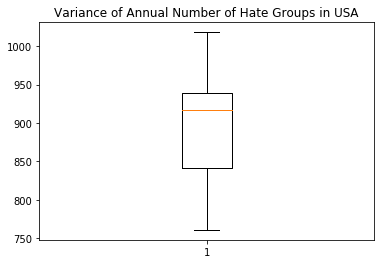

In [29]:
plt.boxplot(overall_year)
plt.title("Variance of Annual Number of Hate Groups in USA")
plt.show()

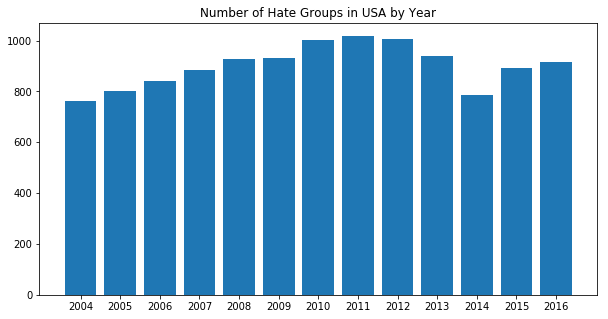

In [30]:
overall_year = overall_year.reset_index()

plt.figure(figsize=(10,5))
plt.bar(x=overall_year.iloc[:,0], height=overall_year.iloc[:,1])
plt.xticks(overall_year.iloc[:,0])
plt.title('Number of Hate Groups in USA by Year')
plt.show()

 ( some exposition about that...)
 
## States by number of hate groups (over the years)

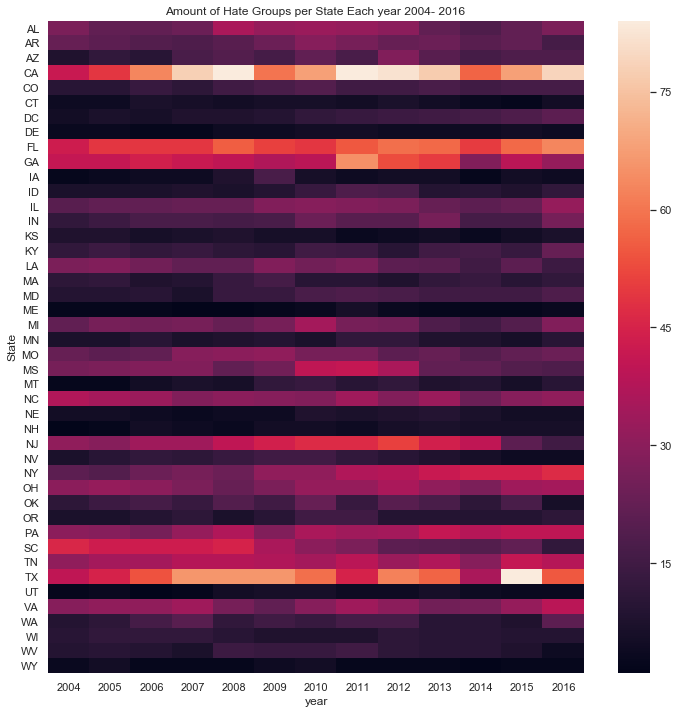

In [31]:
sns.set()                      

count_by_state = hatemaps.groupby(['State', 'year'])['Group Name'].count().unstack().dropna()

f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(count_by_state,
            linewidths=0, ax=ax)
plt.title('Amount of Hate Groups per State Each year 2004- 2016 ')
plt.show()


The heatmap above is a little bit hard to read but at a glance, shows the general amount of hate groups in each state is low, and shows a couple of outliers such as Texas, especially in 2015, GA, FL and CA in general. Let's take a look at the boxplot of each state to get another look.

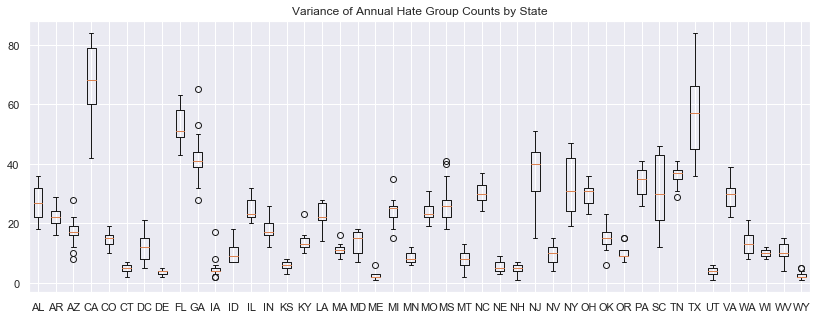

In [32]:
plt.figure(figsize=(14,5))
plt.boxplot(count_by_state, labels=count_by_state.index.values)
plt.title("Variance of Annual Hate Group Counts by State")
plt.show()

With this look, it is easier to see the outliers and how different they are from the other states - namely, CA, FL, GA, and TX. It is also interesting to see what each state's average and standard deviation is. CA seems to have a higher amount on average and a wide range, while TX, for example, has a wider ranger and a lower number on average.

## Number and size of of different hate (group) types

The hate groups are divided up into the following hate types.

In [33]:
list(set(hatemaps['Hate Type']))

['Anti-Muslim',
 'Racist Skinhead',
 'Anti-LGBT',
 'Ku Klux Klan',
 'Neo-Confederate',
 'White Nationalist',
 'General/Other',
 'Anti-Immigrant',
 'Neo-Nazi',
 'Holocaust Denial',
 'Radical Traditional Catholicism',
 'Racist / Hate Music',
 'Black Nationalist',
 'Christian Identity']

Let's look at how many distinct hate groups make a part of each hate type below. I'm going to split this into two separate charts to make it a little easier to look at. I'll split the groups up at the median of the means of each hate type size.

In [34]:
# size of hate types by number of groups in each

group_year = hatemaps.groupby(['year','Hate Type'])['Group Name'].nunique().unstack()

larger_half = []
smaller_half = []

for col in group_year.columns.values:
    # if the mean size of this hate type is greater than the median mean size of all the types..
    if np.mean(group_year[col]) >= np.median(np.mean(group_year)):
        larger_half.append(col)
    else:
        smaller_half.append(col)
        
# making smaller dataframes
larger_ht = hatemaps.loc[hatemaps['Hate Type'].isin(larger_half)]
smaller_ht = hatemaps.loc[hatemaps['Hate Type'].isin(smaller_half)]

In [35]:
# grouping them to get the count of Groups per Hate Type in each dataframe
larger_grouped = larger_ht.groupby(['year','Hate Type'])['Group Name'].nunique().unstack()
smaller_grouped = smaller_ht.groupby(['year','Hate Type'])['Group Name'].nunique().unstack()

# pushing the index over so "year" becomes a column
larger_grouped = larger_grouped.reset_index()
smaller_grouped = smaller_grouped.reset_index()

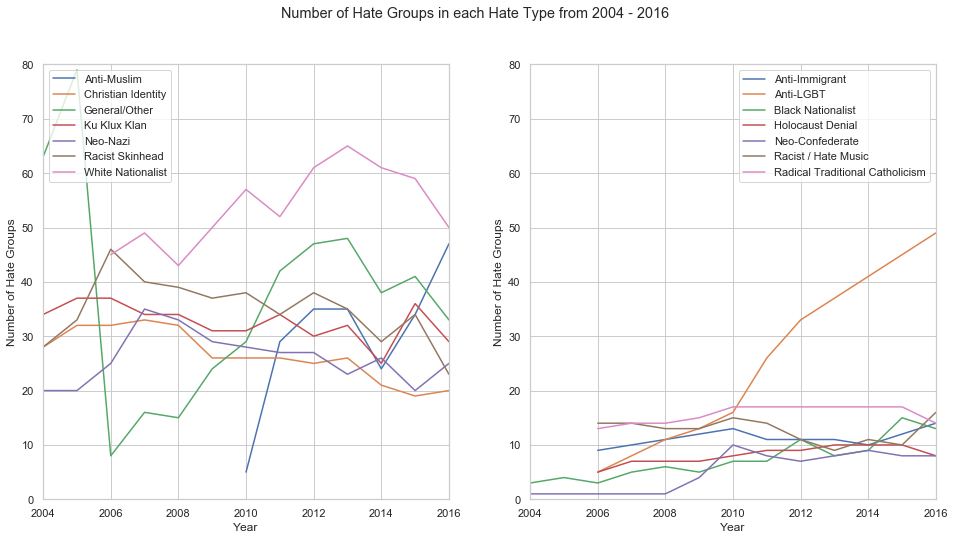

In [36]:
# plotting on 2 separate line plots to see the data more clearly

sns.set(style="whitegrid")

plt.figure(figsize=(16,8))
plt.suptitle('Number of Hate Groups in each Hate Type from 2004 - 2016')

plt.subplot(1,2,1)
ax = plt.gca()

for col in larger_half:
    larger_grouped.plot(kind='line',x='year',y=col,ax=ax)
plt.ylim(0,80)
plt.xlim(2004,2016)
ax.set(ylabel='Number of Hate Groups', xlabel="Year")

plt.subplot(1,2,2)
ax = plt.gca()
for col in smaller_half:
    smaller_grouped.plot(kind='line',x='year',y=col,ax=ax)
plt.ylim(0,80)
plt.xlim(2004,2016)
ax.set(ylabel='Number of Hate Groups', xlabel="Year")


plt.show()

Because these charts are easy to read with one standardized y axis, I plotted them that way to simplify comparison. It appears that the number of White Nationalist groups was higher than the majority of the the other groups, and generally increased from 2004 until 2013, at which point the number of groups started to drop. 

There is also an interesting outlier in General / Other, with a large number in year 2005, and then a large drop. This could be due to reclassifying the groups, perhaps, so we'll take that with a grain of salt.

Also of note is that some groups either only existed, or were counted, from year 2006. Finally, while most Hate Types do not have a steady increase, there are 2 exceptions to this - Anti-Muslim (had one drop in 2014, but other than that, steady incline) and Anti-LGBT.

## What is the geographical spread of each hate group and hate type?

Let's take a quick general look at the number of states that have a presence of each hate type, organized by year, so we can see the growth / decline of each over time.

Because of the large number of hate types, and the amount of states varying widely across those hate types, I split this into 3 separate charts that each have unique y axis ranges. It is a good idea to keep that in mind when comparing the information. 

In [37]:
# pivot! ish
state_type = hatemaps.groupby(['year',
                  'Hate Type'])['State'].nunique().dropna()
state_type = state_type.reset_index()

# splitting up the data again so the charts are easier to read

one = ['White Nationalist','Ku Klux Klan',   'Neo-Nazi',     
        'Christian Identity', 'Black Nationalist',]

two = ['Anti-Muslim', 'Anti-LGBT',  'Neo-Confederate',
       'General/Other','Racist Skinhead', ]

three = ['Anti-Immigrant', 'Holocaust Denial',
         'Racist / Hate Music', 'Radical Traditional Catholicism']


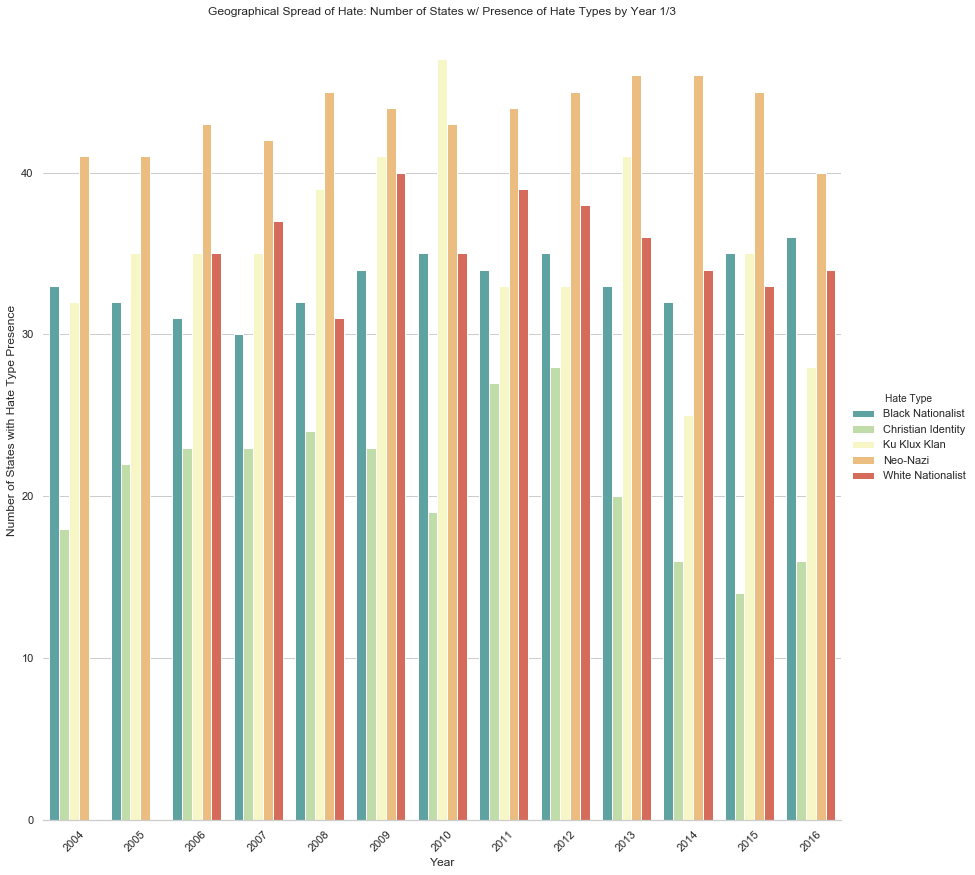

In [38]:
# chart 1
sns.set(style="whitegrid")

g = sns.catplot(x="year", y="State", hue="Hate Type", 
                data=state_type.loc[state_type['Hate Type'].isin(one)],
               height=12, kind="bar", palette="Spectral_r", ci=95)
g.despine(left=True)
g.set_ylabels("Number of States with Hate Type Presence")
g.set_xlabels("Year")
g.set_xticklabels(rotation=45)
plt.title('Geographical Spread of Hate: Number of States w/ Presence of Hate Types by Year 1/3')
plt.show()

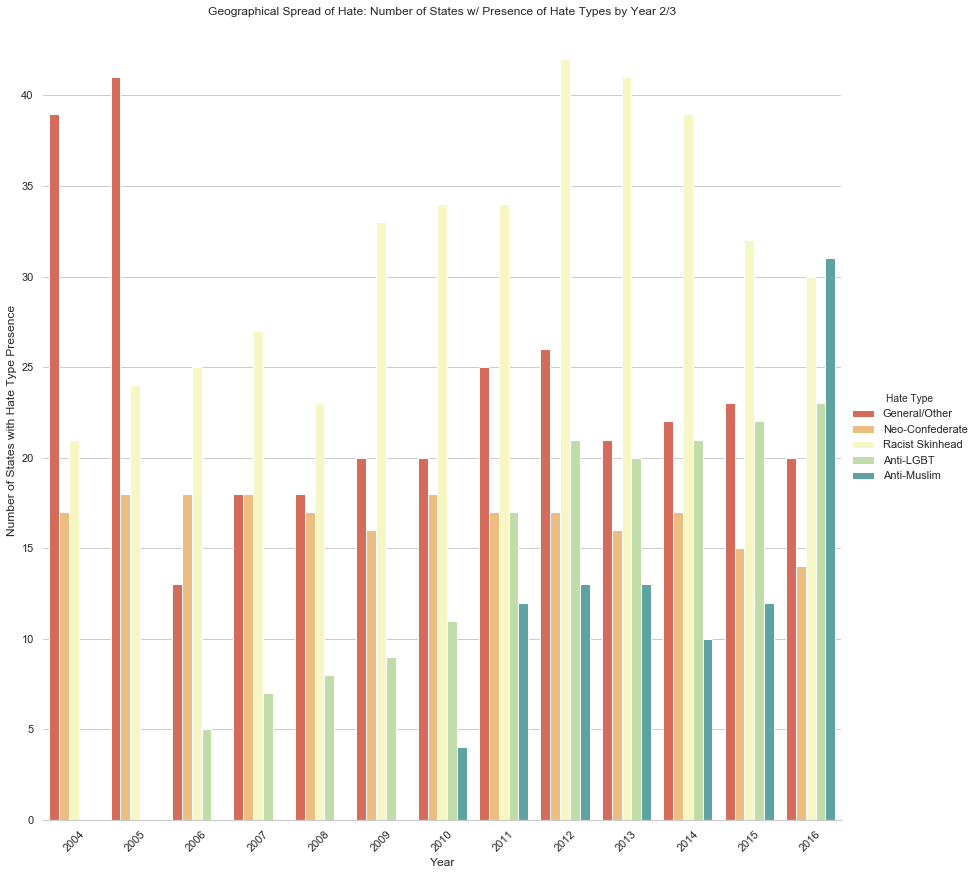

In [39]:
# chart 2

g = sns.catplot(x="year", y="State", hue="Hate Type", 
                data=state_type.loc[state_type['Hate Type'].isin(two)],
               height=12, kind="bar", palette="Spectral", ci=95)
g.despine(left=True)
g.set_ylabels("Number of States with Hate Type Presence")
g.set_xlabels("Year")
g.set_xticklabels(rotation=45)
plt.title('Geographical Spread of Hate: Number of States w/ Presence of Hate Types by Year 2/3')
plt.show()

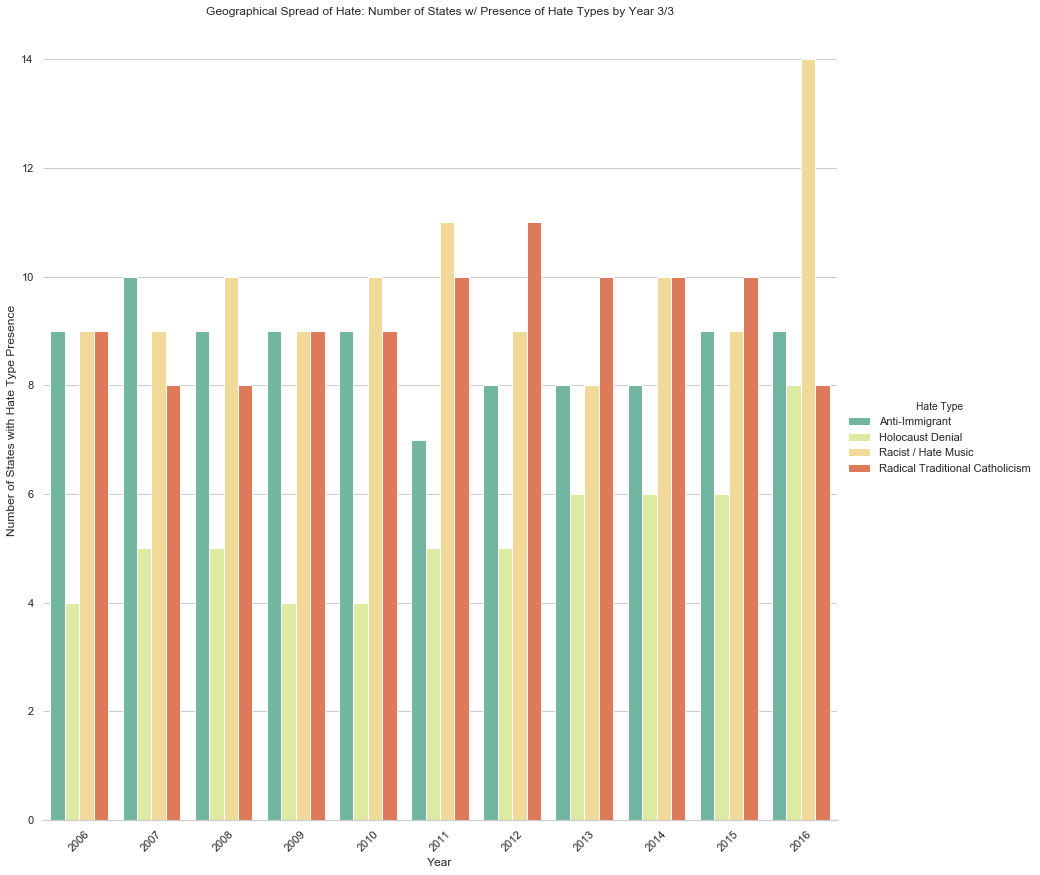

In [40]:
# chart 3

g = sns.catplot(x="year", y="State", hue="Hate Type", 
                data=state_type.loc[state_type['Hate Type'].isin(three)],
               height=12, kind="bar", palette="Spectral_r", ci=95)
g.despine(left=True)
g.set_ylabels("Number of States with Hate Type Presence")
g.set_xlabels("Year")
g.set_xticklabels(rotation=45)
plt.title('Geographical Spread of Hate: Number of States w/ Presence of Hate Types by Year 3/3')
plt.show()

(talk about that a little bit)

Let's look closer at the hate groups, and see which ones are present in the largest number of cities and states.

In [41]:
hatemaps.groupby(['year','Group Name'])['City'].count().sort_values(ascending=False).head(10)


year  Group Name                 
2012  nation of islam                105
2007  league of the south            102
2006  league of the south            100
2005  league of the south             97
2004  league of the south             96
2008  league of the south             90
2011  nation of islam                 84
2016  nation of islam                 81
2006  national socialist movement     81
2015  nation of islam                 80
Name: City, dtype: int64

It looks like the Nation of Islam has had the largest geographical presence by city. Below, grouped by unique states, it shows a different picture. From this data, it appears that some of the groups that exist in more cities are more concentrated in certain states.

In [42]:
hatemaps.groupby(['year',
                  'Group Name'])['State'].nunique().sort_values(ascending=False).head(10)

year  Group Name                                     
2013  national socialist movement                        43
2012  national socialist movement                        41
2014  national socialist movement                        40
2011  national socialist movement                        39
2015  national socialist movement                        39
2010  brotherhood of klans knights of the ku klu klan    38
2013  loyal white knights of the ku klu klan             38
2006  national socialist movement                        35
2009  national socialist movement - nsm                  35
2012  nation of islam                                    34
Name: State, dtype: int64